In [232]:
# jupyter extension that allows reloading functions from imports without clearing kernel :D
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [233]:
import cv2
import dlib
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
import numpy as np
import json
import scipy

In [234]:
from utils import better_plotter
from utils import crop_face_with_padding, crop_face_with_padding_corners
from utils import apply_affine_transformation, get_triagulation
from utils import create_mask_from_image, overlay_mask, paste_mask_on_canvas, find_bounding_box, paste_on_background
from utils import upper_left_background_rc

## Prepare detectors

In [235]:
'''
Human face detector
'''
human_face_detector = dlib.get_frontal_face_detector()
human_landmarks_predictor = dlib.shape_predictor('predictor/shape_predictor_68_face_landmarks.dat')

## Load `source` and `target` images

In [433]:
images = {
    # Cats with preset facial landmarks
    "cat": 'images/cats/pexels-photo-736532.jpeg',
    "cat2": 'images/cats/28462689-cat-kitten-gaze-regard-glance-look-head.jpg',
    "cat3": 'images/cats/Red cat - Vladimir Aleksandrov.png',
    "cat-dalle": 'images/cats/DALLE 2023-12-06 12.13.22.png',
    "vermeer-cat": 'images/cats/vermeer-cat.jpg',
    # Artworks
    "vermeer": 'images/artworks/Girl with a Pearl Earring - Johannes Vermeer.jpg',
    "gothic": 'images/artworks/American Gothic - Grant Wood.jpg',
    "orlando": 'images/artworks/Orlando - Sandra Flood.png',
    "giovanni": 'images/artworks/Portrait of Giovanni di Nicolao Arnolfini - Jan van Eyck.png',
    "vsevolod": 'images/artworks/Portrait of Vsevolod Mikhailovich Garshin - Ilya Repin.png',
    "man-ring": 'images/artworks/Man With a Ring 1617 - Werner van den Valckert.png',
    "young-girl": 'images/artworks/Portrait of a Young Girl - Petrus Christus.png'
}

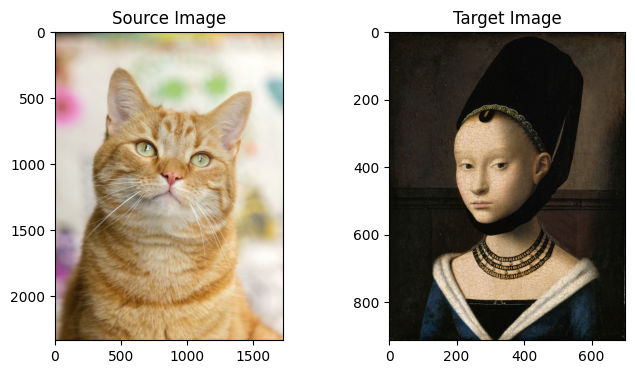

In [460]:
# Load the source and target images, 
# as well as setting up the variables for their grayscale copy
source_img_select = "cat"
target_img_select = "young-girl"

source_img = cv2.imread(images[source_img_select])
target_img = cv2.imread(images[target_img_select])

better_plotter([
    {
        "img": cv2.cvtColor(source_img, cv2.COLOR_BGR2RGB),
        "title": "Source Image"
    },
    {
        "img": cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB),
        "title": "Target Image"
    },
], plot_size=(8, 4))

## Process `source` image

### Getting feature points

Skip this if you want to load the preset feature points from `.json` file

In [448]:
def get_human_face_landmarks(img):
    # If detecting human face
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    faces_detected = human_face_detector(img_gray)
    
    if len(faces_detected) > 0: print(f'Total number of face detected: {len(faces_detected)}.')
    else: print('No face detected.')

    face_landmarks = []
    face_images = []
    for face in faces_detected:
        landmarks = human_landmarks_predictor(img_gray, face)
        face_landmarks.append([(landmarks.part(n).x, landmarks.part(n).y) for n in range(0, 68)])
        face_images.append(crop_face_with_padding(img, face, padding_ratio=0))

    return face_landmarks, face_images

def get_cat_face_landmarks(landmark_load):
    # Manual face load
    manual_cat_68_features = []
    with open(landmark_load, 'r') as file:
        data = json.load(file)
        manual_cat_68_features = [(point['x'], point['y']) for point in data['points']]
        
    return [manual_cat_68_features]

In [461]:
# Change this option depending on if you want to port a cat or human face in the source image
option = 'cat'

if option == 'cat':
    landmark_json_path = "landmarks/" + ".".join(images[source_img_select].split("/")[-1].split(".")[0:-1]) + ".json"
    print(landmark_json_path)
    source_face_landmarks_list = get_cat_face_landmarks(
        landmark_json_path
        # "landmarks/DALLE 2023-12-06 12.13.22.json"
    )
elif option == 'human':
    source_face_landmarks_list, source_faces = get_human_face_landmarks(source_img)
    source_faces_display = []
    for i in range(0, len(source_faces)):
        source_faces_display.append({
            "img": source_faces[i],
            "title": f'Face {i}'
        })
    better_plotter(source_faces_display, plot_size=(2 * len(source_faces), 2))

print(f'Detecting {option} face in source iamge')
print("Source face landmarks:")
print(source_face_landmarks_list)

landmarks/pexels-photo-736532.json
Detecting cat face in source iamge
Source face landmarks:
[[(382, 886), (408, 986), (432, 1065), (478, 1147), (523, 1206), (584, 1268), (648, 1322), (728, 1365), (825, 1393), (933, 1389), (1018, 1364), (1091, 1339), (1158, 1304), (1211, 1267), (1250, 1214), (1300, 1162), (1349, 1069), (563, 792), (620, 777), (704, 770), (767, 804), (795, 849), (996, 894), (1055, 867), (1114, 858), (1178, 881), (1231, 936), (907, 909), (903, 963), (898, 1018), (893, 1067), (809, 1082), (843, 1106), (881, 1124), (911, 1118), (951, 1113), (604, 854), (665, 829), (730, 852), (765, 930), (691, 944), (635, 916), (1015, 967), (1070, 926), (1126, 919), (1176, 962), (1142, 1011), (1082, 1020), (738, 1257), (772, 1219), (817, 1194), (865, 1183), (916, 1220), (948, 1266), (957, 1307), (916, 1308), (881, 1293), (852, 1285), (811, 1284), (772, 1282), (787, 1239), (827, 1229), (858, 1221), (887, 1236), (927, 1268), (884, 1258), (855, 1242), (822, 1248)]]


## Process `target` image

For target image, we only care about human face.

Total number of face detected: 1.


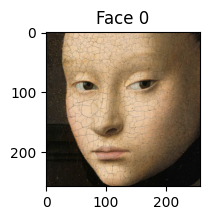

Target face landmarks:
[[(200, 400), (197, 425), (200, 451), (209, 477), (219, 503), (232, 524), (247, 545), (261, 563), (281, 569), (307, 566), (338, 553), (370, 535), (397, 511), (415, 482), (424, 450), (426, 416), (425, 382), (200, 371), (208, 363), (221, 361), (236, 364), (250, 371), (282, 370), (304, 361), (328, 357), (350, 359), (371, 369), (263, 400), (260, 422), (257, 443), (253, 464), (245, 476), (253, 480), (263, 483), (274, 479), (285, 475), (215, 397), (224, 393), (237, 393), (249, 402), (236, 405), (223, 404), (305, 400), (318, 392), (332, 391), (345, 394), (333, 403), (319, 404), (244, 511), (249, 505), (257, 500), (265, 504), (273, 500), (288, 504), (307, 510), (291, 518), (277, 522), (267, 524), (258, 523), (251, 519), (248, 511), (258, 510), (266, 511), (274, 510), (301, 509), (275, 509), (266, 510), (258, 509)]]


In [462]:
target_face_landmarks_list, target_faces = get_human_face_landmarks(target_img)
target_faces_display = []
for i in range(0, len(target_faces)):
    target_faces_display.append({
        "img": target_faces[i],
        "title": f'Face {i}'
    })
better_plotter(target_faces_display, plot_size=(2 * len(target_faces), 2))

print("Target face landmarks:")
print(target_face_landmarks_list)

## Preview for the both landmarks

In [463]:
source_face_landmarks = source_face_landmarks_list[0]
target_face_landmarks = target_face_landmarks_list[0]

Number of feature points in source face: 68, first point is at (382, 886)
Number of feature points in target face: 68, first point is at (200, 400)


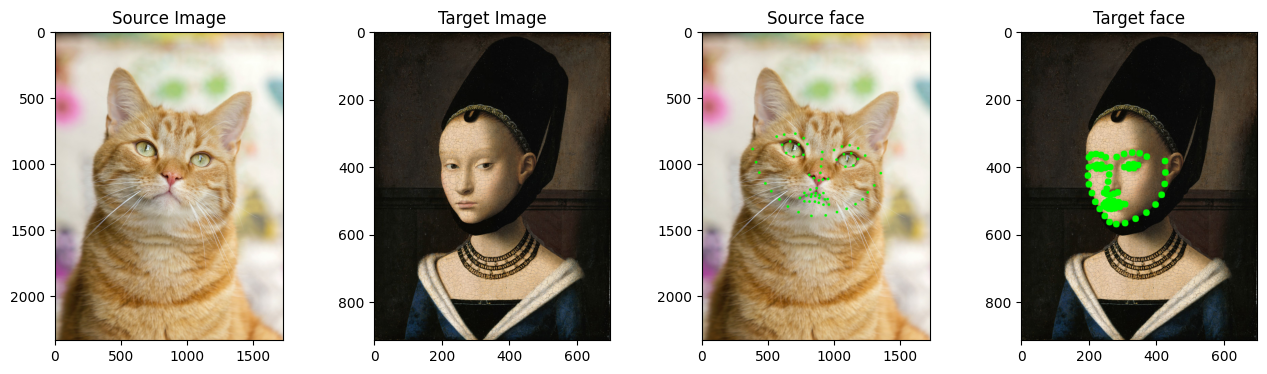

In [464]:
source_img_draw_faces = source_img.copy()
for pt in source_face_landmarks:
    cv2.circle(source_img_draw_faces, (pt[0], pt[1]), 10, (0, 255, 0), -1)

target_img_draw_faces = target_img.copy()
for pt in target_face_landmarks:
    cv2.circle(target_img_draw_faces, (pt[0], pt[1]), 10, (0, 255, 0), -1)

print(f'Number of feature points in source face: {len(source_face_landmarks)}, first point is at {source_face_landmarks[0]}')
print(f'Number of feature points in target face: {len(target_face_landmarks)}, first point is at {target_face_landmarks[0]}')

better_plotter([
    {
        "img": cv2.cvtColor(source_img.copy(), cv2.COLOR_BGR2RGB),
        "title": "Source Image"
    },
    {
        "img": cv2.cvtColor(target_img.copy(), cv2.COLOR_BGR2RGB),
        "title": "Target Image"
    },
    {
        "img": cv2.cvtColor(source_img_draw_faces, cv2.COLOR_BGR2RGB),
        "title": "Source face"
    },
    {
        "img": cv2.cvtColor(target_img_draw_faces, cv2.COLOR_BGR2RGB),
        "title": "Target face"
    }
], plot_size=(16, 4))

## Calculating the convex hull

The convex hull provides a way to define the region of interest on the face. It helps in isolating the face or specific facial features from the rest of the image, ensuring that transformations or manipulations are confined to the face only.

In [465]:
source_hull = []
target_hull = []

# The area that we will be mapping between faces
hull_index_to_map = cv2.convexHull(
    np.array(target_face_landmarks), 
    returnPoints = False
)

# find the facial landmark points on both faces that are within the hull of the face we are basing our map off of
for i in range(0, len(hull_index_to_map)):
    index = int(hull_index_to_map[i])
    source_hull.append(source_face_landmarks[index])
    target_hull.append(target_face_landmarks[index])

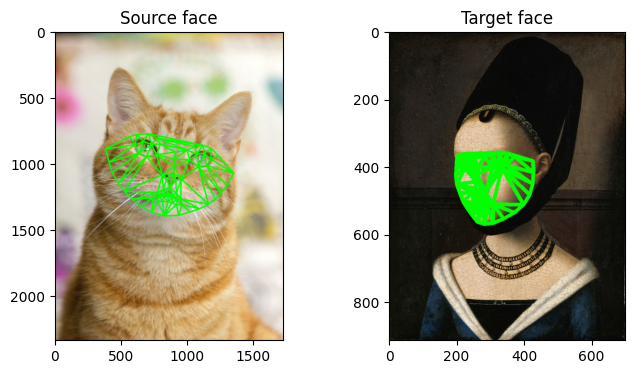

In [466]:
# divide the boundary of the face into triangular sections to morph
delauney_source = get_triagulation(source_img, source_face_landmarks)
delauney_target = get_triagulation(target_img, target_face_landmarks)

source_img_delauney_faces = source_img.copy()
target_img_delauney_faces = target_img.copy()

for t in delauney_source:
    pt1, pt2, pt3 = source_face_landmarks[t[0]], source_face_landmarks[t[1]], source_face_landmarks[t[2]]
    cv2.line(source_img_delauney_faces, pt1, pt2, (0, 255, 0), 10)  # Line from pt1 to pt2
    cv2.line(source_img_delauney_faces, pt2, pt3, (0, 255, 0), 10)  # Line from pt2 to pt3
    cv2.line(source_img_delauney_faces, pt3, pt1, (0, 255, 0), 10)  # Line from pt3 to pt1
    
for t in delauney_target:
    pt1, pt2, pt3 = target_face_landmarks[t[0]], target_face_landmarks[t[1]], target_face_landmarks[t[2]]
    cv2.line(target_img_delauney_faces, pt1, pt2, (0, 255, 0), 10)  # Line from pt1 to pt2
    cv2.line(target_img_delauney_faces, pt2, pt3, (0, 255, 0), 10)  # Line from pt2 to pt3
    cv2.line(target_img_delauney_faces, pt3, pt1, (0, 255, 0), 10)  # Line from pt3 to pt1
    
better_plotter([
    {
        "img": cv2.cvtColor(source_img_delauney_faces, cv2.COLOR_BGR2RGB),
        "title": "Source face"
    },
    {
        "img": cv2.cvtColor(target_img_delauney_faces, cv2.COLOR_BGR2RGB),
        "title": "Target face"
    }
], plot_size=(8, 4))
    
# print("delauney_source")
# print(delauney_source)
# print("-")
# print("delauney_target")
# print(delauney_target)

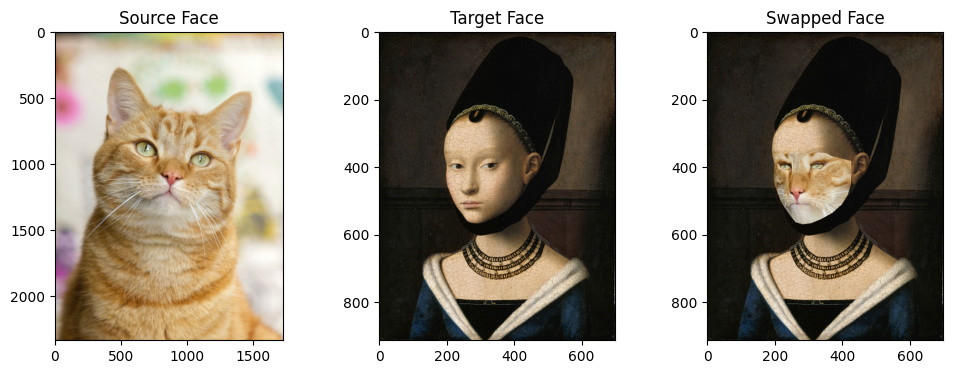

In [467]:
# warp the source triangles onto the target face
direct_blend = apply_affine_transformation(delauney_source, source_face_landmarks, target_face_landmarks, source_img, target_img)

# Display the images
better_plotter([
    {
        "img": cv2.cvtColor(source_img, cv2.COLOR_BGR2RGB),
        "title": "Source Face"
    },
    {
        "img": cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB),
        "title": "Target Face"
    },
    {
        "img": cv2.cvtColor(direct_blend, cv2.COLOR_BGR2RGB),
        "title": "Swapped Face"
    }
], plot_size=(12, 4))

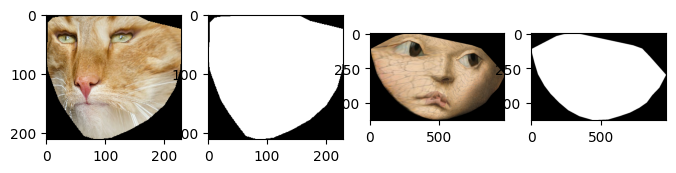

In [468]:
# Get only the morphed face with the size as the target_img
source_face_morphed = apply_affine_transformation(delauney_source, source_face_landmarks, target_face_landmarks, source_img, np.zeros_like(target_img))
target_face_morphed = apply_affine_transformation(delauney_target, target_face_landmarks, source_face_landmarks, target_img, np.zeros_like(source_img))

# Get the bounding box coordinates of the morphed face
source_face_morphed_bounding_box = find_bounding_box(target_face_landmarks)
target_face_morphed_bounding_box = find_bounding_box(source_face_landmarks)

blend_src = crop_face_with_padding_corners(
    source_face_morphed, 
    (source_face_morphed_bounding_box['top_left'], source_face_morphed_bounding_box['top_right'], 
     source_face_morphed_bounding_box['bottom_left'], source_face_morphed_bounding_box['bottom_right']),
    padding_ratio = 0
)
blend_src_mask = create_mask_from_image(blend_src)

blend_tgt = crop_face_with_padding_corners(
    target_face_morphed, 
    (target_face_morphed_bounding_box['top_left'], target_face_morphed_bounding_box['top_right'], 
     target_face_morphed_bounding_box['bottom_left'], target_face_morphed_bounding_box['bottom_right']),
    padding_ratio = 0
)
blend_tgt_mask = create_mask_from_image(blend_tgt)

# better_plotter([
#     {
#         "img": source_face_morphed,
#         "title": ""
#     },
#     {
#         "img": target_face_morphed,
#         "title": ""
#     }
# ], plot_size=(8, 2))

# Display the images
better_plotter([
    {
        "img": blend_src,
        "title": ""
    },
    {
        "img": blend_src_mask,
        "title": ""
    },
    {
        "img": blend_tgt,
        "title": ""
    },
    {
        "img": blend_tgt_mask,
        "title": ""
    },
], plot_size=(8, 2))

In [471]:
# Coordinate of the center of the mask, with respect to the target image
source_center = (
    source_face_morphed_bounding_box['top_left'][0] + (source_face_morphed_bounding_box['top_right'][0] - source_face_morphed_bounding_box['top_left'][0]) // 2,
    source_face_morphed_bounding_box['top_left'][1] + (source_face_morphed_bounding_box['bottom_left'][1] - source_face_morphed_bounding_box['top_left'][1]) // 2,
)

target_center = (
    target_face_morphed_bounding_box['top_left'][0] + (target_face_morphed_bounding_box['top_right'][0] - target_face_morphed_bounding_box['top_left'][0]) // 2,
    target_face_morphed_bounding_box['top_left'][1] + (target_face_morphed_bounding_box['bottom_left'][1] - target_face_morphed_bounding_box['top_left'][1]) // 2,
)

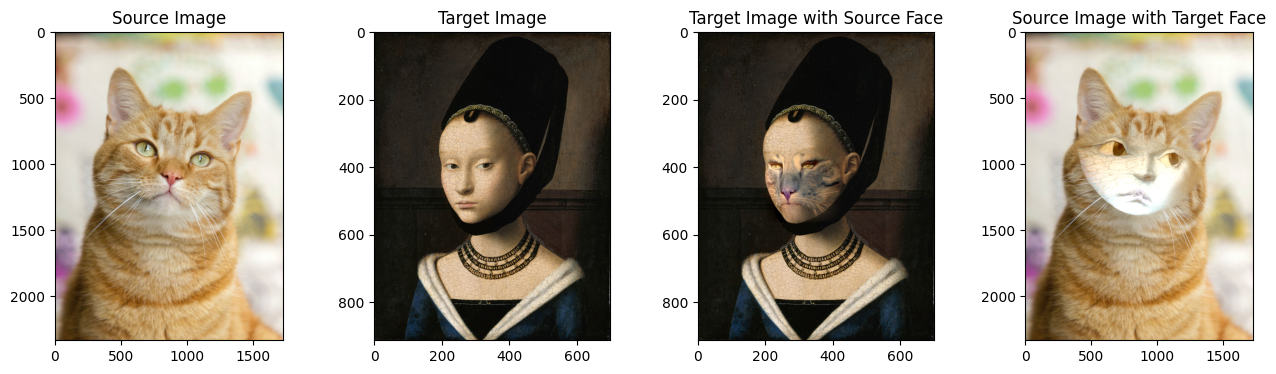

In [472]:
# target_faceless_img = overlay_mask(
#     cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB).copy(), 
#     blend_src_mask, 
#     center, 
#     # (190, 160, 132) # vermeer
#     (152, 123, 81) # american gothic
# )
# mixed_clone_2 = cv2.seamlessClone(blend_src, cv2.cvtColor(target_faceless_img, cv2.COLOR_RGB2BGR), blend_src_mask, center, cv2.NORMAL_CLONE)

clone_method = cv2.NORMAL_CLONE

mixed_clone_1 = cv2.seamlessClone(blend_src, target_img, blend_src_mask, source_center, clone_method)
mixed_clone_2 = cv2.seamlessClone(blend_tgt, source_img, blend_tgt_mask, target_center, clone_method)

mixed_clone_mixed = cv2.seamlessClone(blend_src, target_img, blend_src_mask, source_center, cv2.MIXED_CLONE)

# Display the images
better_plotter([
    {
        "img": cv2.cvtColor(source_img, cv2.COLOR_BGR2RGB),
        "title": "Source Image"
    },
    {
        "img": cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB),
        "title": "Target Image"
    },
    {
        "img": cv2.cvtColor(mixed_clone_1, cv2.COLOR_BGR2RGB),
        "title": "Target Image with Source Face"
    },
    {
        "img": cv2.cvtColor(mixed_clone_2, cv2.COLOR_BGR2RGB),
        "title": "Source Image with Target Face"
    }
], plot_size=(16, 4))

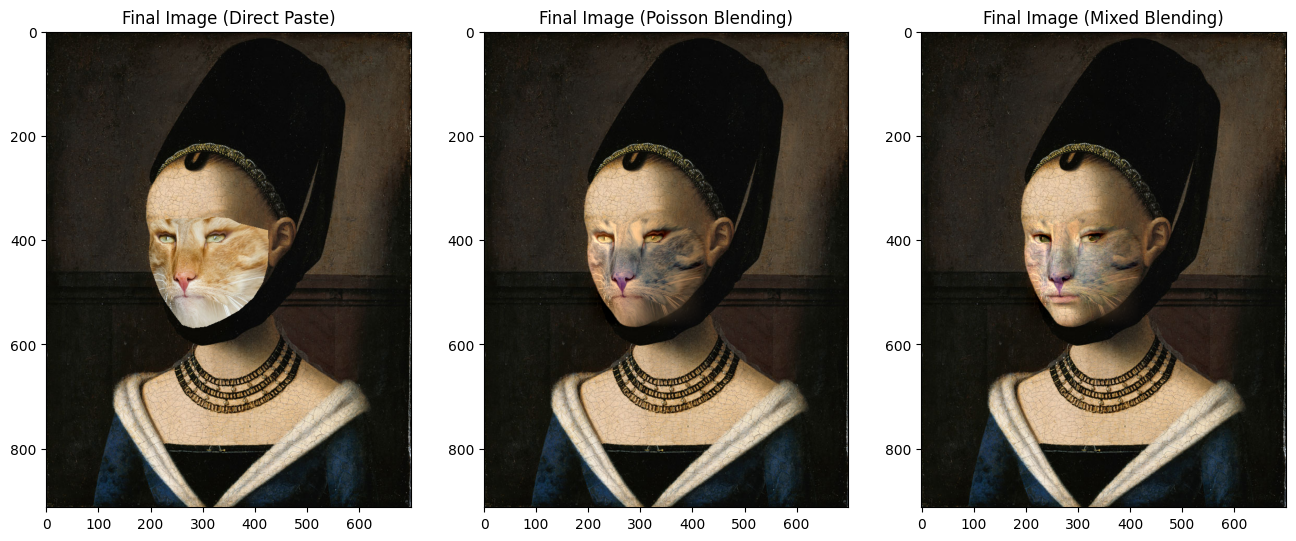

In [473]:
# Display the images
better_plotter([
    # {
    #     "img": cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB),
    #     "title": "Target Image"
    # },
    {
        "img": cv2.cvtColor(direct_blend, cv2.COLOR_BGR2RGB),
        "title": "Final Image (Direct Paste)"
    },
    {
        "img": cv2.cvtColor(mixed_clone_1, cv2.COLOR_BGR2RGB),
        "title": "Final Image (Poisson Blending)"
    },
    {
        "img": cv2.cvtColor(mixed_clone_mixed, cv2.COLOR_BGR2RGB),
        "title": "Final Image (Mixed Blending)"
    }
], plot_size=(16, 7))